# Unsupervised Cluster Model Evaluation

Unsupervised Cluster Model Evaluation Script

TODO: 
- Add evaltion for for SVM & KMEANS so we can see what groups it predicted
- For GMM standarize code
- The minimum vs knee point for optimal is different in the GMM vs SVM and KMEANS



Overview:
This script provides a comprehensive framework for evaluating unsupervised clustering models, specifically focusing on K-Means and Gaussian Mixture Models (GMM). It encompasses the entire workflow from data generation to model evaluation against true labels. The script is designed to be flexible, allowing adjustments to dataset complexity and facilitating comparisons between clustering algorithms.

Features:
- Generation of synthetic datasets with adjustable complexity parameters (number of samples, features, clusters, and cluster standard deviation).
- Preprocessing of datasets to ensure model compatibility.
- Application of K-Means clustering with evaluation based on distortion (inertia) and determination of the optimal number of clusters using the Elbow Method.
- Application of GMM with evaluation based on BIC (Bayesian Information Criterion) and AIC (Akaike Information Criterion).
- Visualization of true cluster groupings and clustering results to facilitate qualitative assessment.
- Modular functions for calculating and plotting distortion, BIC, AIC, and identifying the knee point in the Elbow Method.
- Evaluation of clustering performance against true labels using Adjusted Rand Index (ARI) and Adjusted Mutual Information (AMI) scores.

Usage:
The script is structured to allow easy modification for different experimental setups. Users can adjust the dataset complexity parameters to explore how different clustering algorithms perform under various conditions. Additionally, the modular design of evaluation functions (e.g., for distortion, BIC/AIC, and performance metrics) enables reuse across different clustering scenarios.

Requirements:
- Python 3.6 or newer
- NumPy, pandas, scikit-learn, Matplotlib, Seaborn

Example Use Case:
The script can be employed to benchmark the performance of K-Means and GMM on synthetic datasets with known ground truth. This is particularly useful in educational settings or as a preliminary step in clustering analysis to select the most appropriate algorithm and parameters for a given dataset. Notice that with more difficult data the knee method might fail but in the case that it does correctly identify the cluster side, it does very well. This proves that knowing the right size is important and that these clustering unsuperized methods are effective.

Note:
While the script includes functionality to ignore all warnings (`warnings.filterwarnings('ignore')`), users are encouraged to review warnings during development to ensure full awareness of any potential issues.


In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')


### Step 1: Creating a Synthetic Dataset
First, we'll create a synthetic dataset with 30 data points and 3 features. This dataset will be engineered to contain some inherent groupings to illustrate how clustering algorithms can identify them.

##### Adjusting Dataset Complexity:

- n_samples: Increase to add more data points, making the dataset larger.
- n_features: Increase to add more dimensions, making the clustering problem more complex.
- centers: Change the number of inherent groupings or clusters within the data.
- cluster_std: Adjust to control the fuzziness of clusters. A higher value results in more overlap between clusters, increasing difficulty.

In [2]:
#More INFO = Easier
#Less Complex = Easier
#Less SCATTER = Easier


# Parameters to adjust dataset complexity
n_samples = 300  # Number of data points ## HOW MUCH INFO
n_features = 5   # Number of features ## HOW COMPLEX
centers = 5      # Number of centers or clusters 
cluster_std = 2.3  # Standard deviation of clusters ##SCATTER 

# Generate synthetic data
X, true_labels = make_blobs(n_samples=n_samples, centers=centers, n_features=n_features, cluster_std=cluster_std, random_state=42)
df = pd.DataFrame(X, columns=[f'Feature_{i+1}' for i in range(n_features)])
print(df.head())

   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5
0  -2.683546  11.252102   6.469748   5.412668  -6.101810
1  -7.501577  -6.658809   6.748241   5.014721   2.605702
2   0.831668   9.846918   5.976901   0.524858  -4.863091
3 -10.385978  -7.003534   4.703497   2.638108  10.564140
4  -4.801286   8.697724   6.868091  -5.341433  -4.966097


### Step 2: Data Preprocessing
Clustering algorithms like K-means require features to be on a similar scale. We'll standardize the features.

In [3]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)


### Step 3: Clustering with K-Means
We'll use the K-Means algorithm to identify clusters within our dataset


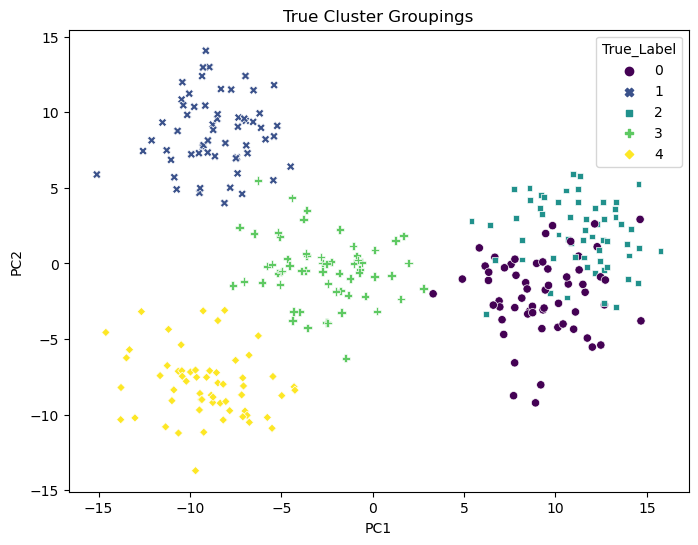

In [4]:
# Applying PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Creating a DataFrame for the PCA-transformed data
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['True_Label'] = true_labels

# Visualizing the true cluster groupings
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='True_Label', data=df_pca, palette='viridis', style='True_Label')
plt.title('True Cluster Groupings')
plt.show()

### Clustering with K-Means and Evaluating Distortion
Distortion measures the sum of squared distances from each point to its assigned center. It's a useful metric for evaluating the compactness of clusters formed by K-Means.

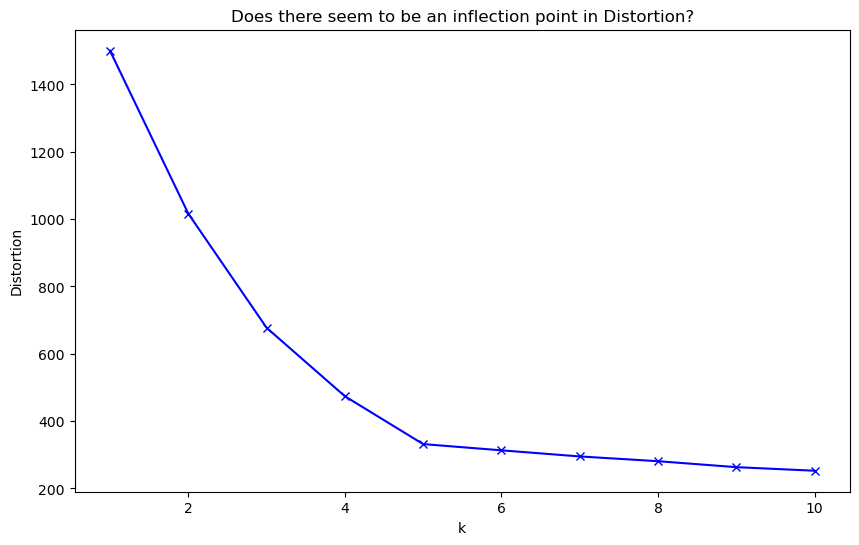

In [19]:

distortions = []
K = range(1, 11)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42)
    kmeanModel.fit(df_scaled)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Does there seem to be an inflection point in Distortion?')
plt.show()


##### Finding Knee

Identifying the "knee" or elbow point from the plot generated by the Elbow Method can sometimes be more art than science, especially when the curve is smooth. However, there are quantitative methods to help find the elbow point more objectively. One popular method involves calculating the curvature or the angle at each point of the plot, looking for the point with the maximum curvature, which is often considered the elbow. Another approach is to use the "Kneedle" algorithm, which attempts to automate the detection of the knee point.

The "knee" or "elbow" method, often used with the Elbow Method in K-Means clustering, provides a visual heuristic for choosing an optimal number of clusters. It looks for a point in the plot of a chosen metric (like inertia or distortion for K-Means, and potentially BIC or AIC for GMM) where the rate of decrease sharply changes. This point signifies a diminishing return on improvement in the metric with the addition of more clusters.

The advantage of the knee/elbow method is its intuitive appeal in visually identifying the point beyond which increasing model complexity (adding more clusters) doesn't yield substantial improvements in the chosen metric. This can help in selecting a model that is sufficiently simple while still capturing the essential structure in the data.

However, it's worth noting that the knee/elbow method also has its limitations:

Subjectivity: Determining the exact location of the "knee" or "elbow" can sometimes be subjective, especially in plots where the inflection point is not very pronounced.
Dependence on Metric: The method's effectiveness depends on the metric used to evaluate model performance. Different metrics might suggest different numbers of optimal clusters.
Bias-Variance Trade-off: While seeking to avoid overfitting by selecting a simpler model, there's also a risk of underfitting if the model is too simple to capture the underlying data structure.
Ultimately, the choice of method for determining the optimal number of clusters/components in unsupervised learning should consider the specific characteristics of the dataset, the goals of the analysis, and the inherent trade-offs of each approach. It's often beneficial to use a combination of methods (including BIC, AIC, and the knee/elbow method) alongside domain knowledge to make a well-rounded decision.

In [6]:

# Function to calculate the distance of each point from a line (first to last point)
def calculate_distances(distortions):
    # Coordinates of the first point
    p1 = np.array([1, distortions[0]])
    # Coordinates of the last point
    p2 = np.array([len(distortions), distortions[-1]])
    
    distances = []
    for i, d in enumerate(distortions, start=1):
        p = np.array([i, d])
        # Calculate the distance from point to line (p1 to p2)
        distance = np.abs(np.cross(p2-p1, p1-p)) / np.linalg.norm(p2-p1)
        distances.append(distance)
    return distances


def find_knee_point(distortions, k_range):
    distances = calculate_distances(distortions)
    optimal_k = distances.index(max(distances)) + 1  # +1 for correct k index
    print(f"Optimal k according to the Elbow Method: {optimal_k}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.axvline(x=optimal_k, linestyle='--', color='r')
    plt.show()
    
    return optimal_k


### Modularizing K-Means Evaluation with Distortion

In [7]:

def evaluate_kmeans_distortion(df_scaled, k_range):
    distortions = []
    for k in k_range:
        kmeanModel = KMeans(n_clusters=k, random_state=42)
        kmeanModel.fit(df_scaled)
        distortions.append(kmeanModel.inertia_)
    return distortions

def plot_distortion(k_range, distortions):
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()


Optimal k according to the Elbow Method: 5


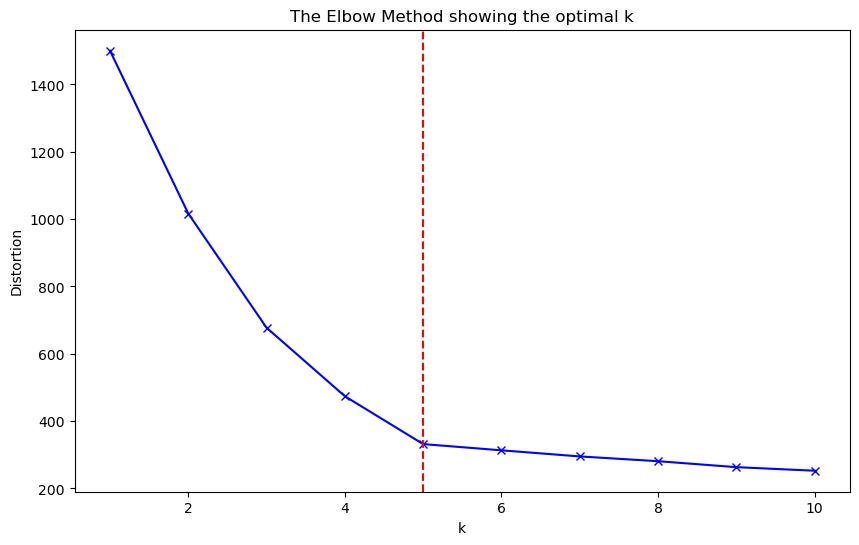

In [8]:
# Evaluate K-Means and plot distortion
k_range = range(1, 11)
distortions = evaluate_kmeans_distortion(df_scaled, k_range)
#plot_distortion(k_range, distortions)

# Find and plot the knee point
optimal_k = find_knee_point(distortions, k_range)

### Modularizing GMM Evaluation with BIC and AIC

In [9]:
def evaluate_gmm_bic_aic(df_scaled, n_components_range):
    bic, aic = [], []
    for n in n_components_range:
        gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42).fit(df_scaled)
        bic.append(gmm.bic(df_scaled))
        aic.append(gmm.aic(df_scaled))
    return bic, aic

def plot_bic_aic(n_components_range, bic, aic):
    plt.figure(figsize=(10, 6))
    plt.plot(n_components_range, bic, label='BIC')
    plt.plot(n_components_range, aic, label='AIC')
    plt.legend()
    plt.xlabel('Number of Components')
    plt.ylabel('Score')
    plt.title('BIC and AIC Scores by Number of Components')
    plt.show()


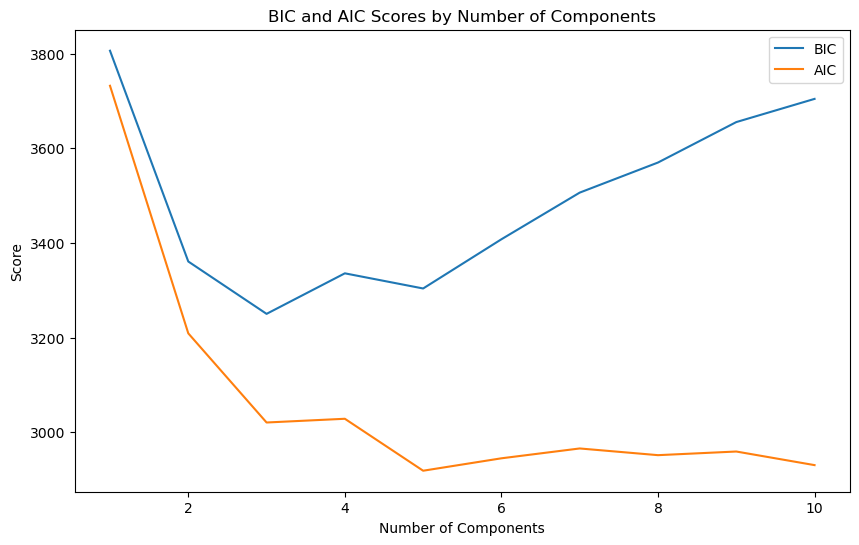

Optimal k according to the Elbow Method: 3


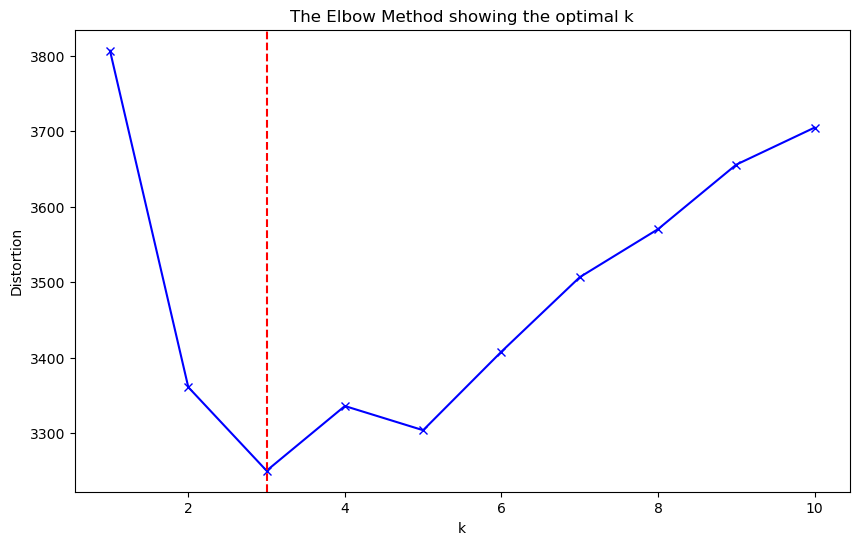

Optimal k according to the Elbow Method: 3


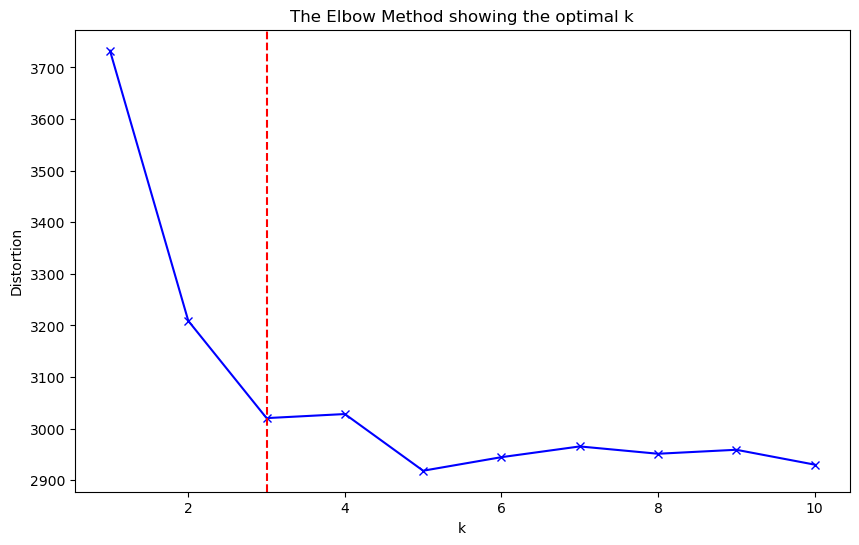

In [10]:


# Evaluate GMM and plot BIC, AIC
n_components_range = np.arange(1, 11)
bic, aic = evaluate_gmm_bic_aic(df_scaled, n_components_range)
plot_bic_aic(n_components_range, bic, aic)

# Find and plot the knee point
optimal_k = find_knee_point(bic, k_range)

# Find and plot the knee point
optimal_k = find_knee_point(aic, k_range)

## EVALUATION

To evaluate how each model did in predicting the true classes, we need to introduce some measures that can help us assess the performance of unsupervised models against true labels. Since unsupervised models don't inherently predict classes but rather group data based on similarity, we need methods to align these groupings with true classes for evaluation. A common approach is to use clustering metrics that can compare the clusters found by the model with the actual classes, such as the Adjusted Rand Index (ARI) or the Mutual Information based scores.

Adding Evaluation of Model Predictions Against True Classes
Let's modularize functions for evaluating clustering performance with ARI and Mutual Information Score, which don't assume knowledge of cluster labels and are hence suitable for assessing unsupervised learning models:

### Adding Evaluation of Model Predictions Against True Classes
Let's modularize functions for evaluating clustering performance with ARI and Mutual Information Score, which don't assume knowledge of cluster labels and are hence suitable for assessing unsupervised learning models:

In [11]:
def evaluate_clustering(true_labels, predicted_labels):
    ari = adjusted_rand_score(true_labels, predicted_labels)
    ami = adjusted_mutual_info_score(true_labels, predicted_labels, average_method='arithmetic')
    
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Adjusted Mutual Info (AMI): {ami:.4f}")

    return ari, ami


### Explanation
- Adjusted Rand Index (ARI): Measures the similarity between two assignments, ignoring permutations and with chance normalization. An ARI score of 1 indicates perfect agreement between the clusters and true classes, while a score close to 0 or negative indicates random or independent assignments.

- Adjusted Mutual Info (AMI): Measures the agreement of the two assignments, discounting the chance agreement. Like ARI, an AMI score of 1 indicates perfect alignment with true labels, and a score close to 0 suggests no mutual information.

By comparing these scores, you can assess how well your unsupervised model has managed to capture the inherent groupings within the data as per the true classes. High scores indicate that your model's clusters align closely with the true classes, suggesting effective capture of the underlying data structure.

In [12]:
# Assuming K-Means has been applied to df_scaled to find clusters
kmeans_labels = KMeans(n_clusters=optimal_k, random_state=42).fit_predict(df_scaled)

# Evaluating K-Means clustering
evaluate_clustering(true_labels, kmeans_labels)


Adjusted Rand Index (ARI): 0.5253
Adjusted Mutual Info (AMI): 0.6722


(0.5253239712477716, 0.6721508530488455)

In [13]:
# Assuming GMM has been applied to df_scaled to find clusters
gmm = GaussianMixture(n_components=optimal_k, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(df_scaled)

# Evaluating GMM clustering
evaluate_clustering(true_labels, gmm_labels)


Adjusted Rand Index (ARI): 0.6044
Adjusted Mutual Info (AMI): 0.7697


(0.6044478648527252, 0.769651119195733)

### Application of GMM

In [14]:
# Assuming df_scaled is your preprocessed dataset
from sklearn.mixture import GaussianMixture

# Initialize GMM with a range of components to evaluate
n_components_range = range(1, 11)


#### Modularizing GMM Evaluation with BIC and AIC


In [15]:
def evaluate_gmm_bic_aic(X, n_components_range):
    bic_scores = []
    aic_scores = []
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
        gmm.fit(X)
        bic_scores.append(gmm.bic(X))
        aic_scores.append(gmm.aic(X))
    return bic_scores, aic_scores

# Evaluate BIC and AIC for a range of n_components
bic_scores, aic_scores = evaluate_gmm_bic_aic(df_scaled, n_components_range)


#### Plotting BIC and AIC Scores

Finding the Optimal Number of Components
This step involves visually inspecting the BIC/AIC plots or automating the process. For simplicity, we'll choose the model with the lowest BIC score as an example.

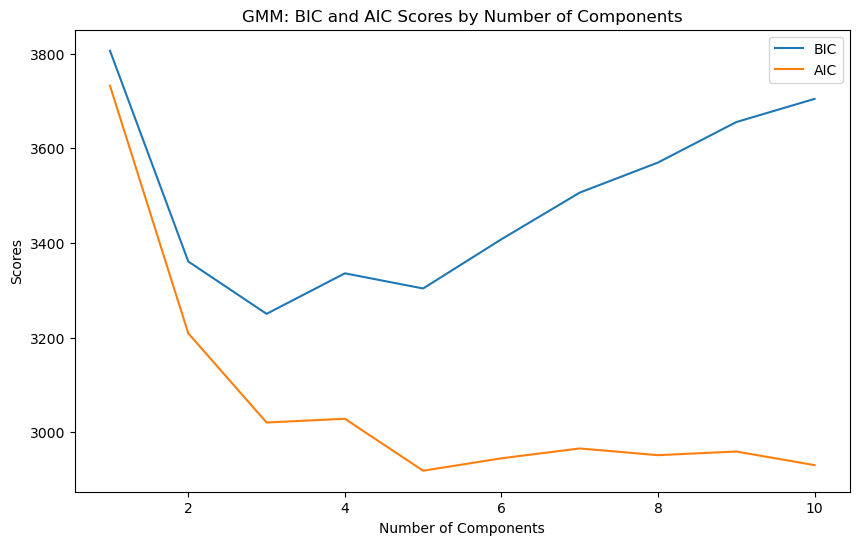

Optimal number of components according to BIC: 3


In [16]:
def plot_bic_aic(n_components_range, bic_scores, aic_scores):
    plt.figure(figsize=(10, 6))
    plt.plot(n_components_range, bic_scores, label='BIC')
    plt.plot(n_components_range, aic_scores, label='AIC')
    plt.xlabel('Number of Components')
    plt.ylabel('Scores')
    plt.legend()
    plt.title('GMM: BIC and AIC Scores by Number of Components')
    plt.show()

plot_bic_aic(n_components_range, bic_scores, aic_scores)

optimal_n_components = n_components_range[np.argmin(bic_scores)]
print(f"Optimal number of components according to BIC: {optimal_n_components}")



In [17]:
def evaluate_clustering(true_labels, predicted_labels):
    from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
    ari = adjusted_rand_score(true_labels, predicted_labels)
    ami = adjusted_mutual_info_score(true_labels, predicted_labels, average_method='arithmetic')
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Adjusted Mutual Info (AMI): {ami:.4f}")

# Apply GMM with the optimal number of components
gmm = GaussianMixture(n_components=optimal_n_components, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(df_scaled)

# Evaluate GMM clustering against true labels
evaluate_clustering(true_labels, gmm_labels)


Adjusted Rand Index (ARI): 0.6044
Adjusted Mutual Info (AMI): 0.7697


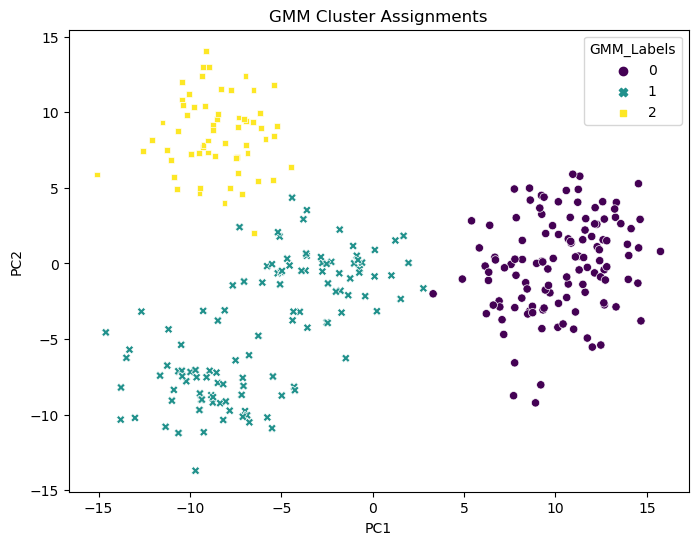

In [18]:
# Assuming you have PCA-transformed data in df_pca
df_pca['GMM_Labels'] = gmm_labels

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='GMM_Labels', data=df_pca, palette='viridis', style='GMM_Labels', legend="full")
plt.title('GMM Cluster Assignments')
plt.show()
